# This notebook is for SV3 results from QSO catalogs

In [9]:
import numpy as np
import fitsio
from matplotlib import pyplot as plt
import os
from astropy.table import Table,join,unique
from desitarget.sv3 import sv3_targetmask

## Look at z success based on Edmond's file

In [37]:
#read Edmond's file
fq = Table.read('/global/cscratch1/sd/edmondc/SHARE/QSO_CATALOG/QSO_catalog_SV3.fits')

In [38]:
#change tile column name to TILEID for matching
fq['TILE'].name = 'TILEID'

In [27]:
fq.dtype.names

('TARGETID',
 'RA',
 'DEC',
 'Z',
 'ZERR',
 'SELECTION_METHOD',
 'Z_QN',
 'Z_RR_ini',
 'SV3_DESI_TARGET',
 'MASKBITS',
 'G_MAG',
 'R_MAG',
 'Z_MAG',
 'W1_MAG',
 'W2_MAG',
 'TILEID',
 'LAST_NIGHT',
 'PETAL',
 'FIBER',
 'LOCATION')

In [39]:
#get the redrock redshift file for everything, then select quasars on their first observation with good fiberstatus
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-sv3-dark-cumulative.fits')
wqso = ff['PRIORITY'] == 103400
wqso &= ff['COADD_FIBERSTATUS'] == 0
ff = ff[wqso]
print(len(ff))

59806


In [41]:
#join, keeping everything from redrock; the repeat columns from the quasar file have '_QF' in the name
ffq = join(ff,fq,keys=['TARGETID','TILEID','LOCATION'],join_type='left',uniq_col_name='{col_name}{table_name}',table_names=['','_QF'])
print(len(ff),len(ffq),len(np.unique(ffq['TARGETID'])))

59806 59806 59630


### Now, we have the data ready to look at redshift success rates

In [42]:
#A "success" is anything that made it to Edmond's file. Masked values in the _QF columns are rows with failures
selgood = ~ffq['Z_QF'].mask 
print(len(ffq[selgood]))
#just for fun, compare to zwarn == 0 and see how many are both selgood and zwarn == 0
wz = ffq['ZWARN'] == 0
print(len(ffq[wz]),len(ffq[wz&selgood]))

37535
50723 35536


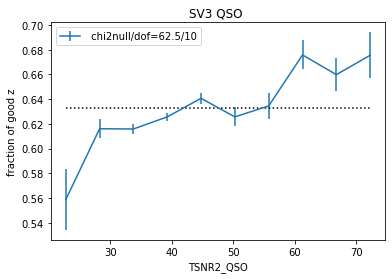

In [49]:
efac = 1 # can change this if we want to plot vs efftime instead of TSNR2
nb = 10
rng=(20,75)
a = np.histogram(ffq[selgood]['TSNR2_QSO'],bins=nb,range=rng)
b = np.histogram(ffq['TSNR2_QSO'],bins=a[1])
#plt.clf()
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
bs = a[1][1]-a[1][0]
vs = (a[1][:-1]+bs/2.)*efac
ol = np.ones(len(vs))*fr
#em = erf((vs-17)/40)*.98

chi2null = np.sum((dl-fr)**2./el**2.)
plt.errorbar(vs,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')
plt.plot(vs,ol,'k:')
plt.title('SV3 QSO ')
plt.xlabel('TSNR2_QSO')
plt.ylabel('fraction of good z')
plt.legend(loc='upper left')
plt.show()  


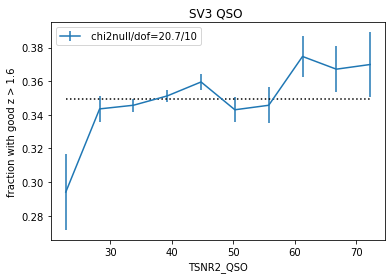

In [50]:
#check fraction with z > 1.6; some fluctuations in z success can be in regions we don't care as much about
efac = 1 # can change this if we want to plot vs efftime instead of TSNR2
nb = 10
rng=(20,75)
selz = ffq['Z_QF'] > 1.6
a = np.histogram(ffq[selgood&selz]['TSNR2_QSO'],bins=nb,range=rng)
b = np.histogram(ffq['TSNR2_QSO'],bins=a[1])
#plt.clf()
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
bs = a[1][1]-a[1][0]
vs = (a[1][:-1]+bs/2.)*efac
ol = np.ones(len(vs))*fr
#em = erf((vs-17)/40)*.98

chi2null = np.sum((dl-fr)**2./el**2.)
plt.errorbar(vs,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')
plt.plot(vs,ol,'k:')
plt.title('SV3 QSO ')
plt.xlabel('TSNR2_QSO')
plt.ylabel('fraction with good z > 1.6')
plt.legend(loc='upper left')
plt.show()  


In [22]:
w = fq['Z']*0 == 0
print(len(fq[w]),len(fq))

122568 122568


In [2]:
ff = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/QSOAlltiles_full.dat.fits')

total number of unique reachable QSO targets is 44601
total number of unique observed QSO targets is 43275
total number of unique QSO targets with good redshifts is 36726
total number of unique QSO targets with good redshifts and spectype qso is 23965
targeting completeness is 0.9702697248940607
redshift success rate is 0.8486655112651647


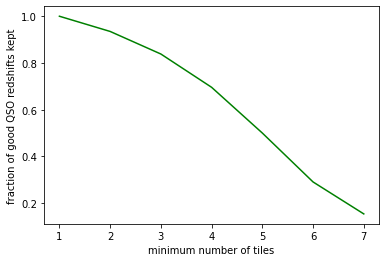

In [14]:
print('total number of unique reachable QSO targets is '+str(len(ff)))
wo = ff['LOCATION_ASSIGNED'] == 1
print('total number of unique observed QSO targets is '+str(len(ff[wo])))
wz = ff['ZWARN'] == 0
print('total number of unique QSO targets with good redshifts is '+str(len(ff[wz])))
wq = ff['SPECTYPE'] == 'QSO'
print('total number of unique QSO targets with good redshifts and spectype qso is '+str(len(ff[wz&wq])))

print('targeting completeness is '+str(len(ff[wo])/len(ff)))
print('redshift success rate is '+str(len(ff[wz])/len(ff[wo])))
ngl = [len(ff[wz])]
ntm = [1]
for nt in range(1,7):
    wt = ff['NTILE'] > nt
    ntm.append(nt+1)
    ngl.append(len(ff[wz&wt]))
plt.plot(ntm,np.array(ngl)/len(ff[wz]),'g-')
plt.xlabel('minimum number of tiles')
plt.ylabel('fraction of good QSO redshifts kept')
plt.show()


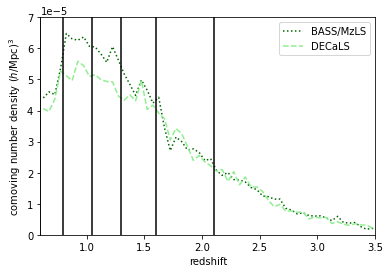

In [9]:
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/QSO_N_nz.dat').transpose()
plt.plot(nz[0],nz[3],':',color='darkgreen',label='BASS/MzLS')
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/QSO_S_nz.dat').transpose()
plt.plot(nz[0],nz[3],'--',color='lightgreen',label='DECaLS')
plt.legend()
plt.xlim(0.6,3.5)
plt.ylim(0,0.00007)
xl = [0.32,0.32]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [0.6,0.6]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [0.8,0.8]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.05,1.05]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.3,1.3]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.6,1.6]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [2.1,2.1]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
plt.xlabel('redshift')
plt.ylabel(r'comoving number density ($h$/Mpc)$^3$')
plt.show()

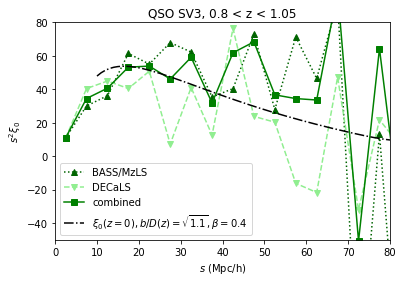

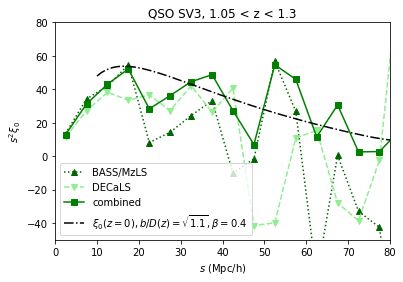

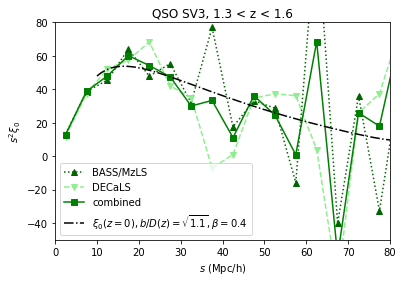

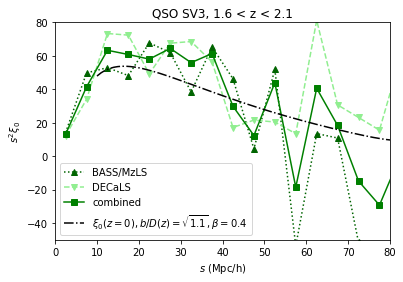

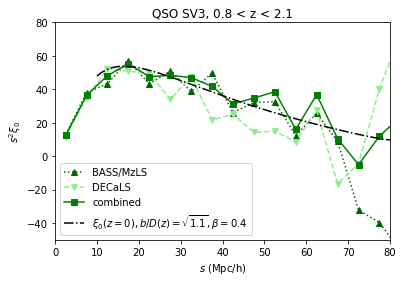

In [13]:
zl = [0.8,1.05,1.3,1.6,2.1]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]

    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testQSO_S'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testQSO'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testQSO_N'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xiln[1],'^:',color='darkgreen',label='BASS/MzLS')
    plt.plot(xil[0],xil[0]**2.*xils[1],'v--',color='lightgreen',label='DECaLS')
    plt.plot(xil[0],xil[0]**2.*xil[1],'s-g',label='combined')
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.1,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.1},\beta=0.4$')

    plt.title('QSO SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,80)
    plt.ylim(-50,80)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

## Looking good, though this should have been easy given high completeness